In [1]:
!python -V

Python 3.13.5


In [2]:
import pandas as pd

In [3]:
import pickle

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error

In [6]:
df = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')
df.head()
print(len(df.columns))

df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df['duration'] = df.duration.dt.total_seconds() / 60

df.duration.mean()
df.duration.std()

print(df.duration.mean())
print(df.duration.std())


len(df[(df.duration >= 1) & (df.duration <= 60)]) / len(df) * 100


print(len(df[(df.duration >= 1) & (df.duration <= 60)]) / len(df) * 100)



categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

print(df[categorical])

19
15.668995167330452
42.594351241920904
98.1220282212598
        PULocationID DOLocationID
0                161          141
1                 43          237
2                 48          238
3                138            7
4                107           79
...              ...          ...
3066761          107           48
3066762          112           75
3066763          114          239
3066764          230           79
3066765          262          143

[3066766 rows x 2 columns]


In [39]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

print(f'Feature matrix size: {X_train.shape}')


target = 'duration'
y_train = df[target].values



lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

#Doesn't work on my env, failing with error "TypeError: got an unexpected keyword argument 'squared'"
#print(f'Train RMSE: {mean_squared_error(y_train, y_pred, squared=False)}')

print(f'Train RMSE: {np.sqrt(root_mean_squared_error(y_train, y_pred))}')


Feature matrix size: (3066766, 519)
Train RMSE: 6.4816674958492415


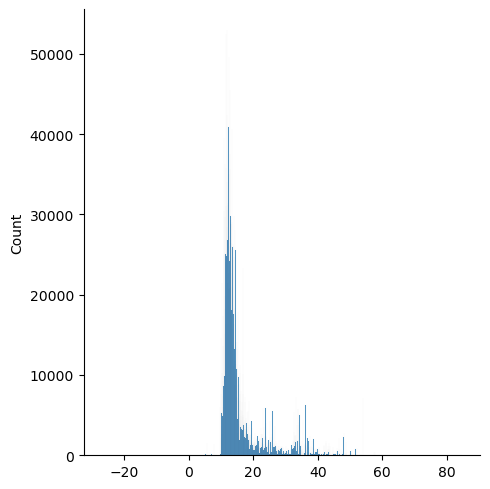

/opt/homebrew/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


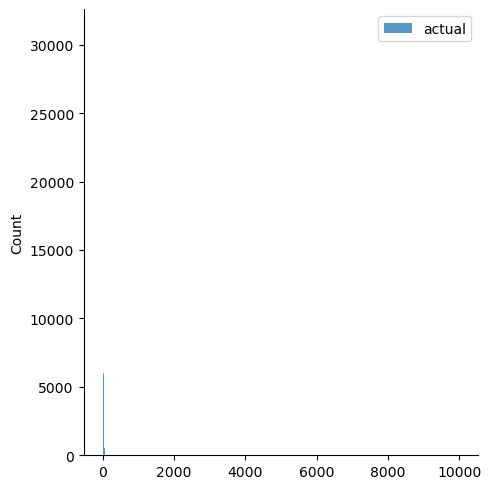

In [ ]:
# sns.distplot - deprecated, used displot)
sns.displot(y_pred, label='prediction')
sns.displot(y_train, label='actual')

plt.legend()

In [49]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df
#print(df)

In [41]:
df_train = read_dataframe('./data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2023-02.parquet')

In [42]:
len(df_train), len(df_val)

(3009173, 2855951)

In [43]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [44]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [45]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [47]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

5.247487085197099

In [50]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [51]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

9.395699095576239